Sage Hahn

Data Science Final Project

'Exploring a range of different methods', In this file I complete the bulk on my exploratory data analysis in answering my research question.


For my approach, it is important to try it on already established problems. The first is a very common one in text processing, using the twenty news groups datatset, imported from sklearn. I will first establish a baseline accuracy by just going through and implimenting a binary test classifier on this dataset.

This baseline example is adpted from http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

In [1]:
#Imports
from sklearn.datasets import fetch_20newsgroups
from sklearn.linear_model import SGDClassifier
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import random
from random import shuffle
import pickle
import nltk
from nltk.stem.snowball import SnowballStemmer
import collections

In [2]:
#Define all of the functions I will be using throughout, defined in the order they are used

def create_test_labels(class_num, test_target):
    '''This function creates the test labels given a valid class between 0-19 for the
    Twenty news dataset, and returns them as an array'''
    y_test = []
    
    for test_entry in test_target:
        if (test_entry == class_num):
            y_test.append(1)
        else:
            y_test.append(0)
            
    return y_test

def create_train_set(class_num, ratio, train_data, train_target):
    '''This function creates the training set data and labels, 
       and needs to bw given the train and test data'''
    X_train = []
    y_train = []

    data = zip(train_data, train_target)

    #First add just all instances of the class
    for entry, label in data:
        if (label == class_num):
            X_train.append(entry)
            y_train.append(1)

    #Now add the rest of the classes according to the ratio
    amount = len(X_train) * ratio
    count = 0

    data = zip(train_data, train_target)

    #Next we will randomly add from the remaining test data by adding the correct ratio of not class X
    for entry, label in data:
        if count < amount:
            if (label != class_num):
                X_train.append(entry)
                y_train.append(0)

                count += 1
                
    return X_train, y_train

def get_metrics(text_clf, X_train, X_test, y_train, y_test):
    '''This function returns various metrics, and assumes global variable twenty_test.data.
       Returns the f1 score, which is a measure of precision and recall'''
    
    #Now fit and classify
    text_clf.fit(X_train, y_train)
    predicted = text_clf.predict(X_test)
    
    f1 = metrics.f1_score(y_test, predicted)
    precision = metrics.precision_score(y_test, predicted)
    recall = metrics.recall_score(y_test, predicted)
    
    return f1, precision, recall

def get_average_f1_ratios(text_clf):
    '''This function recieves a classifer as an input, and iterates over all
       possible different classes, getting the average f1, precision and recall scores over
       the different possible ratios of training data. It returns the averages, as three arrays.'''
    
    #Init the ratios list w/ a 0 at first, to make the ratios index align with the ratio
    f1_ratios = [0]
    precision_ratios = [0]
    recall_ratios = [0]
    
    #Run for ratios 1-10
    for ratio in range(1,11):
        
        #Take the average F1 score for each class
        f1_total = 0
        precision_total = 0
        recall_total = 0
        
        #For each class,
        for cl in range(20):
            y_test = create_test_labels(cl, twenty_test.target)
            X_train, y_train = create_train_set(cl, ratio, twenty_train.data, twenty_train.target)
            
            #Get the metrics
            f1, precision, recall = get_metrics(text_clf, X_train, twenty_test.data, y_train, y_test)
    
            #Compute the total
            f1_total += f1
            precision_total += precision
            recall_total += recall
        
        #Compute the average, and add to the respective array
        f1_ratios.append(f1_total / 20)
        precision_ratios.append(precision_total / 20)
        recall_ratios.append(recall_total / 20)
        
        print("At step: ", ratio)
        
    return f1_ratios, precision_ratios, recall_ratios

def preproc(source):
    '''preproc is used to preprocess the twenty newsgroup data to
       conform with the rest of the data used'''
    
    #The output array
    dest = []
    
    for entry in source:

        words = nltk.word_tokenize(entry.lower()) #Convert to lowercase

        ent = ""

        #Stem each word, and re add to entry
        for word in words:
            word = stemmer.stem(word)

            ent = ent + " " + word

        dest.append(ent)
        
    return dest

def createCorpus(read_paths):
    '''Create a corpus, takes in a series of read paths, joins them together,
       and returns the results as a corpus of text documents '''
    
    corpus = []
    posts = []
    
    #For each file to load, load the pkl array, and add it to corpus
    for path in read_paths:
        with open(path, 'rb') as fp:
            posts = pickle.load(fp)

        #add that file to the corpus
        corpus = corpus + posts
    
    return corpus

def createQuickTrainingData(subject_keys, ratio):
    '''Creates a quick classifier from key words, though it assumes corpus is defined,
       and returns X,y where X is the training data and y are the labels. As input it takes
       subject keywords, and a training ratio- this is used a helper function to quickly test a method
       of augmenting data'''

    #Store instances here
    lines_with_key = []
    
    #For each line in the corpus, only add if not already present
    for line in corpus:

        found = False
        for key in subject_keys:
            if (key in line) and (not found):
                lines_with_key.append(line)
                found = True

    y = []

    for line in lines_with_key:
        y.append(1)

    #Add a random number of items based on the ratio given
    rand_items = random.sample(corpus, (len(lines_with_key)*ratio))
    
    X = lines_with_key + rand_items

    #If not the desired class, label as 0
    for line in lines_with_key:
        for num in range(ratio):
            y.append(0)
            
    return X, y

def GridSearch(loss_functions, n_grams, max_features_options, ratio_range, word_keys):
    '''My version of GridSearch returning f1 score, precision and recall,
       given different loss_functions, n_gram settings, options for max_features, and ratios'''
    
    #I will store the results in a weird way, results will hold a 2d lists, 1d with the scores, 1d with the label info
    results = []

    #For updates on progress
    r = 0
    final_r = ((ratio_range[1]-ratio_range[0]) * len(loss_functions) * len(n_grams) * len(max_features_options))

    #2-7 should be enough
    for ratio in range(ratio_range[0],ratio_range[1]):
        
        X, y = createQuickTrainingData(word_keys, ratio)

        #For each different classifier option
        for loss_f in loss_functions:
            for gram in n_grams:
                for feat in max_features_options:
                    
                    #Define the clasifier based on the different parameters
                    text_clf = Pipeline([('vect', CountVectorizer(ngram_range=gram, max_features=feat)),('tfidf', TfidfTransformer()),
                             ('clf', SGDClassifier(loss=loss_f, penalty='l2', alpha=1e-3,
                               random_state=22, max_iter=5))])

                    label = [ratio, loss_f, gram, feat]

                    #Add to the weird 2d list the score + label
                    results.append([get_metrics(text_clf, X, X_test, y, y_test), label])

                    r += 1

                    #Print progress updates
                    if (r % 25 == 0):
                        print(r, "/", final_r)
                        
    return results

def printF1(results):
    '''Sorts the results by f1 score, and print out the top 10, and bottom 5,
       lastly, return the bestF1 score'''
    
    sorted_results = sorted(results,key=lambda x: (x[0][0]), reverse=True)

    bestF1 = sorted_results[0][0][0]
    
    print("Top 10")
    for line in sorted_results[:10]:
        print("f1 score: ", line[0][0], "for", line[1])

    print("Bottom 5")
    for line in sorted_results[-5:]:
        print("f1 score: ", line[0][0], "for", line[1])
        
        
    return bestF1

def get_N_Gram_Count(sentence_list, n):
    '''Given a list of sentences, and an int n, returns a Counter, with 
       counts for the all possible n-gram's in the sentence_list '''
    
    #Define the counter
    cnt = collections.Counter()
    
    
    for line in sentence_list:
        words = nltk.word_tokenize(line)
    
        for i in range(len(words) - n):
            
            word = ""

            #Create the n gram
            for c in range(n):
                word = word + " " + words[i+c]

            #Add the count
            cnt[word] += 1

    #return the counter
    return cnt

def ModifiedGridSearch(loss_functions, n_grams, max_features_options, ratio_range, class_num, class_keys):
    '''modfied version of GridSearch from above, returning f1 score, precision and recall,
       given different loss_functions, n_gram settings, options for max_features, and ratios.'''
    #I will store the results in a weird way, results will hold a 2d lists, 1d with the scores, 1d with the label info
    results = []

    #For updates on progress
    r = 0
    final_r = ((ratio_range[1]-ratio_range[0]) * len(loss_functions) * len(n_grams) * len(max_features_options))
    
    #Create y_test
    y_test = create_test_labels(class_num, twenty_test.target)

    for ratio in range(ratio_range[0],ratio_range[1]):
        
        X = []
        y = []
        
        #Get the X and y train based on the ratio
        X_train, y_train = create_train_set(class_num, ratio, twenty_train_data_proc, twenty_train.target)
        
        X, y = createQuickTrainingData(class_keys, ratio)
        X = X + X_train
        y = y + y_train

        #For each different classifier option
        for loss_f in loss_functions:
            for gram in n_grams:
                for feat in max_features_options:

                    text_clf = Pipeline([('vect', CountVectorizer(ngram_range=gram, max_features=feat)),('tfidf', TfidfTransformer()),
                             ('clf', SGDClassifier(loss=loss_f, penalty='l2', alpha=1e-3,
                               random_state=22, max_iter=5))])


                    label = [ratio, loss_f, gram, feat]

                    #Add to the weird 2d list the score + label
                    results.append([get_metrics(text_clf, X, X_test, y, y_test), label])

                    r += 1

                    #Print progress updates
                    if (r % 25 == 0):
                        print(r, "/", final_r)
                        
    return results


def getKeyWords(class_num, ratio):
    '''Given a class number and a ratio, print out the most common 1,2 n grams,
       this is used as a helper function in helping a user generate key words'''
    
    X_train = []
    y_train = []
    
    #Redfine X_train and y_test
    y_test = create_test_labels(class_num, twenty_test.target)
    X_train, y_train = create_train_set(class_num, ratio, twenty_train_data_proc, twenty_train.target)
    
    train_data = zip (X_train, y_train)

    #Init class_x and and not_class_x arrays
    class_X = []
    not_class_X = []

    for line,label in train_data:
        if (label == 1):
            class_X.append(line)
        else:
            not_class_X.append(line)
    
    #Print out which class this is for
    print(twenty_train.target_names[class_num])
    
    #For 1,2 grams print out the most common, that are the least common in not class x
    for i in range(1,3):
        cnt_class_X = get_N_Gram_Count(class_X, i)
        cnt_not_class_X = get_N_Gram_Count(not_class_X, i)

        cnt_class_X.subtract(cnt_not_class_X)

        print("N gram =", i)
        print(cnt_class_X.most_common(10))

def printPR(results):
    '''Sorts the results by preicison instead, and print out the top 10'''
    sorted_results = sorted(results,key=lambda x: (x[0][1]), reverse=True)

    print("Top 10")
    for line in sorted_results[:10]:
        print("prescision score: ", line[0][1], "for", line[1], "recall: ", line[0][2])


In [3]:
#Declae the stemmer
stemmer = SnowballStemmer("english", ignore_stopwords=True)

In [4]:
#Load the dataset from sklearn
twenty_train = fetch_20newsgroups(subset='train', shuffle ='true')
twenty_test = fetch_20newsgroups(subset='test', shuffle ='true')

In [5]:
#Confirm the length of the train and test datasets
print(len(twenty_train.data))
print(len(twenty_test.data))

11314
7532


In [6]:
#There are as the name suggests twenty different categories for this dataset
twenty_train.target

array([7, 4, 4, ..., 3, 1, 8])

I will start with the code directly from sklearns page for my baseline, just with modified huber instead in this exploration.

In [7]:
text_clf = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='modified_huber', penalty='l2', alpha=1e-3,
                       random_state=42, max_iter=5, tol=None))])

It is important to note though, my problem is defined slightly differently then the baseline sklearn example, namely I am only intrested in tested is this chunk of writing a part of class X or not, a binary question. It is therefore neccisarry for me to create a modified dataset before fitting and testing.

In [8]:
#To create a modified dataset,
y_train = []
y_test = []

#Go through testing this approach, by changing class 0 to be 1, otherwise change to 0
for train_entry in twenty_train.target:
    if (train_entry == 0):
        y_train.append(1)
    else:
        y_train.append(0)
        
for test_entry in twenty_test.target:
    if (test_entry == 0):
        y_test.append(1)
    else:
        y_test.append(0)

I for initial testing, create a modified y_train and y_test where all instances of class 0 becomes class 1, and everything else becomes class 0, turning the problem into one of binary classification.

In [9]:
text_clf.fit(twenty_train.data, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ty='l2', power_t=0.5, random_state=42,
       shuffle=True, tol=None, verbose=0, warm_start=False))])

In [10]:
#Now lets run our prediction on the test data and see how we do
predicted = text_clf.predict(twenty_test.data)
np.mean(predicted == y_test) 

0.96893255443441317

Alright that seems like a pretty good result, though we are going to want to take a closer look, as the mean could be misleading. 

In [11]:
#Print out both the metric report, and the confusion matrix
print(metrics.classification_report(y_test, predicted))
metrics.confusion_matrix(y_test, predicted)

             precision    recall  f1-score   support

          0       0.97      1.00      0.98      7213
          1       0.91      0.29      0.45       319

avg / total       0.97      0.97      0.96      7532



array([[7204,    9],
       [ 225,   94]])

Alright so as expected, what this classifier does is gets a good score by labelling almost everything as not class X. This can be seen in the recall score of .07... which is quite bad. So in essence, of the 319 instances of class 0, 297 were predicted wrong, and only 22 were right. What the classifier did well though, is only predicted 2 instances incorrectly.

Let's now see if we can get better results by training the model with less instances of not class X. 

In [12]:
X_train = []
y_train = []

data = zip(twenty_train.data, twenty_train.target)

#First add just all instances of the class
for entry, label in data:
    if (label == 0):
        X_train.append(entry)
        y_train.append(1)

In [13]:
#Check how large this class is
len(X_train)

480

In [14]:
#Now test the approach with a ratio of say 4
amount = len(X_train) * 4
count = 0

data = zip(twenty_train.data, twenty_train.target)

#Next we will randomly add from the remaining test data by adding the first len(X_train * 4)
for entry, label in data:
    if count < amount:
        if (label != 0):
            X_train.append(entry)
            y_train.append(0)
            
            count += 1
            
len(X_train)

2400

In [15]:
#Now fit and classify
text_clf.fit(X_train, y_train)

predicted = text_clf.predict(twenty_test.data)
print(np.mean(predicted == y_test))
print(metrics.classification_report(y_test, predicted))
print(metrics.confusion_matrix(y_test, predicted))

0.976633032395
             precision    recall  f1-score   support

          0       0.99      0.99      0.99      7213
          1       0.73      0.71      0.72       319

avg / total       0.98      0.98      0.98      7532

[[7131   82]
 [  94  225]]


Alright, this is starting to look a lot better. We will now use the helper functions create_test_labels, and create_train_set, as we have gone manually through the steps and see that it works.

In [16]:
#A quick test of the functions, on class 1 this time, and a ratio of 5
y_test = create_test_labels(0, twenty_test.target)
X_train, y_train = create_train_set(0, 4, twenty_train.data, twenty_train.target)
print(get_metrics(text_clf, X_train, twenty_test.data, y_train, y_test))

(0.71884984025559118, 0.73289902280130292, 0.70532915360501569)


As the most important metric at this point is the precision and recall score of class X, I set up the function get_metrics to return the f1 score, which gets at both of those metrics, as well as oth individually. Before changing the classifier, I want to first take a look at whats going on between the relationship between precision and recall as the training data ratio changes.

Additionally, I set up a function earlier that calculates the average F1 score over every class, for each possible ratio, with an option to change the text classifier, we will now run that function.

In [17]:
#Run the function,
f1_ratios, precision_ratios, recall_ratios = get_average_f1_ratios(text_clf)

At step:  1
At step:  2
At step:  3
At step:  4
At step:  5
At step:  6
At step:  7
At step:  8
At step:  9
At step:  10


Notably this process is fairly intensive to run, which means it most likely won't be practical to re-run in full as we move onto the next step of refining/redefining the classifier used. Hopefully though, what running this more intesive search will provide is a usable ratio to use for the remainder of the expiriment. We are of course then operating under the assumption that the results will not change too dramatically over different classifiers. It should be also noted that I restricted the search to ratios 1-10, as that covers all reasonable cases, as well as the maximum ratio becomes unpredicatable around 13-14 when it will trigger out of bound errors. 

Now, we will plot the results to give an idea of what is going on.

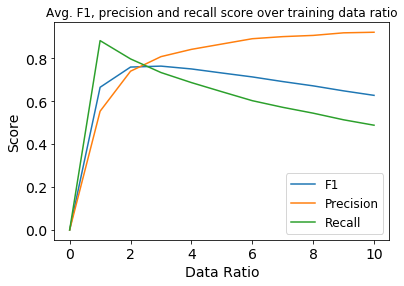

In [18]:
#First plot the f1 ratios
plt.plot(f1_ratios, label='F1')
plt.plot(precision_ratios, label='Precision')
plt.plot(recall_ratios, label='Recall')


title = "Avg. F1, precision and recall score over training data ratio"
plt.title(title)
plt.xlabel("Data Ratio", fontsize=14)
plt.ylabel("Score", fontsize=14)

plt.legend(prop={'size': 12})

plt.tick_params(labelsize=14) 
plt.show()

As the graph above shows, it appears a ratio of around 2 provides us with the best F1 score. The graph also contains other information though, like the recall spike at ratio 1, and precision continuing to increase as ratio falls.

Lets look again the pipeline as defined now

text_clf = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3,
                       random_state=42, max_iter=5, tol=None))])
                       
We can test using a grid search to see if we can find better parameters, though this is also very intensive, so we won't attempt to run it on the range of different classes and ratios.

In [19]:
#Try the following different parameter options
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
               'tfidf__use_idf': (True, False),
               'clf__alpha': (1e-2, 1e-3)}

#Define the grid search classifier
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)

Now we can test this on say class 0.

In [20]:
y_test = create_test_labels(0, twenty_test.target)
X_train, y_train = create_train_set(1, 2, twenty_train.data, twenty_train.target)

gs_clf = gs_clf.fit(X_train, y_train)

In [21]:
get_metrics(gs_clf, X_train, twenty_test.data, y_train, y_test)

(0.0023474178403755869, 0.001876172607879925, 0.003134796238244514)

Well something looks very off there... in any case grid search in our case doesn't even represent the best solution in terms of F1 score, so it is safe to default to the previously defined classifier. 

Note: When I tried using a custom defined metric of F1 score, sklearn would give me strange errors, so I define my own grid search togive more control.

In [22]:
#I'm just gonna redefine our initial pipeline as it worked well
text_clf = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='modified_huber', penalty='l2', alpha=1e-3,
                       random_state=42, max_iter=5, tol=None))])

I've switched back to the previous pipeline, since the results were good. That being said, the last thing I would like to try is taking a look at the twenty news dataset under the same preproccessing steps as the rest of the data, to see what type of an effect this has. Note: after considering turning the newsgroup data into discrete sentences, I decided it would be better to not. The reason being, the label extends over the whole 500 word chunk rather then each sentence, so it would therefore label a lot of the sentences that were not about the subject as about the subject.

In [23]:
#Call the preproc function to create a preprocessed version of each
twenty_train_data_proc = preproc(twenty_train.data)
twenty_test_data_proc = preproc(twenty_test.data)

In [24]:
#And lets now run the test from earlier again, but with the processed data
y_test = create_test_labels(0, twenty_test.target)
X_train, y_train = create_train_set(0, 4, twenty_train_data_proc, twenty_train.target)
print(get_metrics(text_clf, X_train, twenty_test_data_proc, y_train, y_test))

(0.733652312599681, 0.74675324675324672, 0.72100313479623823)


Compare the results above, to (0.71884984025559118, 0.73289902280130292, 0.70532915360501569),
Where the first number is the F1 score, the second is precision and the third is recall. So after running the pre-proc steps, the performance actually increased a little bit, not much, but a little. 

Now with a baseline metric of performance established we ar e ready to test using unlabelled data in a few different ways.

The options are:
1. From scratch, using just keyword searches to build the initial training set.
2. From scratch, by training a simple classifier.
3. As a supplement to a supervised learning problem, using keywords from labelled data.
4. As a supplement to a supervised learning problem, using a modified classifier.

I will proceed through testing exploring each option in turn. Starting with number 1, it is fairly ambigious where to begin, and as the problem is defined we are quite unlikely to get results better then our baseline. This is to be expected though, as the intended role of option 1 is not to preform better then a supervised learning problem, but merely to preform better then just a keyword search. Since that is the case, metrics for this option, and for number 2 for that matter, should be evaluated with the training set, as well as the test set, and in comparison to a comprable key word search.

To begin lets choose a subject, say class 1, comp.graphics

In [25]:
print("Subject:, ", twenty_train.target_names[1])

#And lets print a few examples, I use the not proccesed one for readability
for i in range(1,25):
    if (twenty_train.target[i] == 1):
        print(twenty_train.data[i])
        

Subject:,  comp.graphics
From: jgreen@amber (Joe Green)
Subject: Re: Weitek P9000 ?
Organization: Harris Computer Systems Division
Lines: 14
Distribution: world
NNTP-Posting-Host: amber.ssd.csd.harris.com
X-Newsreader: TIN [version 1.1 PL9]

Robert J.C. Kyanko (rob@rjck.UUCP) wrote:
> abraxis@iastate.edu writes in article <abraxis.734340159@class1.iastate.edu>:
> > Anyone know about the Weitek P9000 graphics chip?
> As far as the low-level stuff goes, it looks pretty nice.  It's got this
> quadrilateral fill command that requires just the four points.

Do you have Weitek's address/phone number?  I'd like to get some information
about this chip.

--
Joe Green				Harris Corporation
jgreen@csd.harris.com			Computer Systems Division
"The only thing that really scares me is a person with no sense of humor."
						-- Jonathan Winters

From: ab@nova.cc.purdue.edu (Allen B)
Subject: Re: TIFF: philosophical significance of 42
Organization: Purdue University
Lines: 39

In article <prestonm.73540

Step 1 involves first looking at the subject matter, and generating some keywords. I'll do my best to brainstorm some that are both broad enough to show up, and specific enough it be associated with computer graphics.

In [26]:
comp_graphics_key_words = ["graphics chip", "graphic workstation", "image coding",
                           "digital imaging", " tiff ", "gnu plot", "computer graphics", "graphics card",
                           "3d graphics", "thinning algorithm", "thinned image", " cgi ", "texture mapping", 
                           "curve separation", "image processing"]

#Store pre-proc keywords here
comp_keys = []

#Go through each key and stem
for key in comp_graphics_key_words:
    words = nltk.word_tokenize(key.lower())

    ent = ""

        #Stem each word, and re add to entry
    for word in words:
        word = stemmer.stem(word)

        ent = ent + " " + word
        
    comp_keys.append(ent)

print(comp_keys)

[' graphic chip', ' graphic workstat', ' imag code', ' digit imag', ' tiff', ' gnu plot', ' comput graphic', ' graphic card', ' 3d graphic', ' thin algorithm', ' thin imag', ' cgi', ' textur map', ' curv separ', ' imag process']


There is of course one large step missing here before these keywords are usable, and this is creating an unlabelled set of data to search through. In preprocessing.ipynb, I prepare each individual dataset for use here. For the scope of this problem I will create this set from the first redditTextBlock of 10 million comments split into sentences, and will merge that with the news, blog and twitter sample text.

In [27]:
read_paths = ['data/redditTextBlock1Proc.pkl', 'data/courseraBlogsProc.pkl', 'data/courseraTwitterProc.pkl',
              'data/courseraNewsProc.pkl']

#Use the createCorpus function to create a Corpus based on the read paths
corpus = createCorpus(read_paths)

In [28]:
#Check the length of the corpus created
len(corpus)

32266806

Lets now use the createQuickTrainingData function defined earlier to search through the Corpus, getting all instances of a line where a keyword is present, as well as, adding based on the ratio given, an amount of negative instances.

In [29]:
X, y = createQuickTrainingData(comp_keys, 3)

In [ ]:
#Define our test set to include all of the avaliable labeled data, both training and test.
X_test = twenty_train_data_proc + twenty_test_data_proc
y_test = create_test_labels(1,list(twenty_train.target) + list(twenty_test.target))

In [31]:
#Sanity check, make sure X_test, and y_test are the same
print(len(X_test))
print(len(y_test))

18846
18846


In [32]:
#Redefine the pipeline just to again see the current settings
text_clf = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()), 
                     ('clf', SGDClassifier(loss='modified_huber', penalty='l2', alpha=1e-3,
                       random_state=42, max_iter=5, tol=None))])

text_clf.fit(X,y)
predicted = text_clf.predict(X_test)

print(metrics.classification_report(y_test, predicted))
print(metrics.confusion_matrix(y_test, predicted))

             precision    recall  f1-score   support

          0       0.96      0.98      0.97     17873
          1       0.39      0.22      0.28       973

avg / total       0.93      0.94      0.93     18846

[[17539   334]
 [  762   211]]


Alright interesting, so from just a 10ish keywords we are able to get .4 precision, and .20 recall... alright that is pretty bad, but at this step we are not exactly expecting perfect results. 

Lets compare these numbers to how just a keyword search performs on the test set.

In [33]:
predicted = []

#Search through the test set, and mark as 1 if the keyword is found otherwise mark 0
for line in X_test:
        found = False
        
        for key in comp_keys:
            if (key in line) and (not found):
                
                #Add 1 if found
                predicted.append(1)
                found = True
        
        #If not found, add 0
        if not found:
            predicted.append(0)

#Lastly, a sanity check
len(predicted)

18846

In [34]:
print(metrics.classification_report(y_test, predicted))
print(metrics.confusion_matrix(y_test, predicted))

base_line = metrics.f1_score(y_test, predicted)

             precision    recall  f1-score   support

          0       0.96      0.99      0.97     17873
          1       0.60      0.18      0.28       973

avg / total       0.94      0.95      0.94     18846

[[17757   116]
 [  796   177]]


Alright, so the baseline keyword search actually performed a little bit better... though this is before any finetuning to the classifier I trained on the corpus data, so that will constitute the next step. This is also notably after looking at the testing data, which in a way is cheating, since to gather key words I looked at examples of key words. Regardless, it sets a good baseline, to try and beat with just a keyword search.


A few things I would like to expiriment with are, a different loss function for the SGD classifier,
different ratios of training data, and use of ngram range in CountVectorizer, and setting max_features.
The different loss functions for this task could be - ‘hinge’, ‘log’, ‘modified_huber’, ‘squared_hinge’, ‘perceptron’. 

Let's try 'hinge','modified huber' and 'perceptron' for the loss functions.

Also note, I will run my own version of a grid search defined earlier to give myself more control over the metric used to evaluate. Also note that I shouldn't need to run the search with all the different ratios, I will try 2-7.

In [35]:
#Params to search over
loss_functions = ['hinge','modified_huber','squared_hinge']
n_grams = [(1,1), (1,2),(1,3)]
max_features_options = [None, 300, 500, 1000]
ratio_range = [2,8]

results = GridSearch(loss_functions, n_grams, max_features_options, ratio_range, comp_keys)

25 / 216
50 / 216
75 / 216
100 / 216
125 / 216
150 / 216
175 / 216
200 / 216


In [36]:
#Save the best result to full_corpus and print the rest
full_corpus = printF1(results)

Top 10
f1 score:  0.367803837953 for [3, 'modified_huber', (1, 3), 300]
f1 score:  0.367521367521 for [3, 'modified_huber', (1, 2), 300]
f1 score:  0.363304981774 for [5, 'modified_huber', (1, 1), 300]
f1 score:  0.36125 for [6, 'modified_huber', (1, 1), 300]
f1 score:  0.357906584131 for [3, 'modified_huber', (1, 2), 500]
f1 score:  0.357824427481 for [3, 'modified_huber', (1, 1), 300]
f1 score:  0.357548240636 for [3, 'modified_huber', (1, 3), 500]
f1 score:  0.356965174129 for [4, 'modified_huber', (1, 2), 300]
f1 score:  0.356027482823 for [4, 'modified_huber', (1, 3), 300]
f1 score:  0.35261707989 for [4, 'modified_huber', (1, 1), 300]
Bottom 5
f1 score:  0.0138476755687 for [6, 'hinge', (1, 2), None]
f1 score:  0.01001001001 for [5, 'hinge', (1, 3), None]
f1 score:  0.00811359026369 for [7, 'hinge', (1, 3), None]
f1 score:  0.00807265388496 for [6, 'hinge', (1, 3), None]
f1 score:  0.008 for [7, 'hinge', (1, 2), None]


Alright, so the modified huber loss function preformed far better, with every single one in the top 10 having loss modified huber. In addition, the max features in the top 20 are around 300-500, with None at the bottom. 

In [37]:
#Try sorting by precision, just as a comparison to the high precision seen in the keyword search
sorted_results = sorted(results,key=lambda x: (x[0][1]), reverse=True)

print("Top 10")
for line in sorted_results[:10]:
    print("precision score: ", line[0][1], "for", line[1], "with recall: ", line[0][2])
    
print("Bottom 10")
for line in sorted_results[-10:]:
    print("precision score: ", line[0][1], "for", line[1],  "with recall: ", line[0][2])

Top 10
precision score:  0.582210242588 for [7, 'modified_huber', (1, 3), 500] with recall:  0.221993833505
precision score:  0.57957957958 for [7, 'modified_huber', (1, 3), 1000] with recall:  0.198355601233
precision score:  0.579411764706 for [7, 'modified_huber', (1, 2), 1000] with recall:  0.20246659815
precision score:  0.574468085106 for [7, 'modified_huber', (1, 2), 500] with recall:  0.221993833505
precision score:  0.573604060914 for [6, 'modified_huber', (1, 3), 500] with recall:  0.232271325797
precision score:  0.562015503876 for [5, 'hinge', (1, 2), 500] with recall:  0.149023638232
precision score:  0.560885608856 for [5, 'hinge', (1, 3), 500] with recall:  0.156217882837
precision score:  0.558024691358 for [6, 'modified_huber', (1, 2), 500] with recall:  0.232271325797
precision score:  0.557422969188 for [6, 'modified_huber', (1, 3), 1000] with recall:  0.204522096608
precision score:  0.557184750733 for [4, 'hinge', (1, 3), 300] with recall:  0.195272353546
Bottom 10

We can also look at the precision and recall scores, as expected, with high precision comeslow recall, and vice versa.

In any case the winner in this round appears to be 'modified_huber' loss, 300 max_features, (1,2) or (1,3) n-gram,
3-4 ratio, these approaches yielfing f1 scores around .36, compared to the simple keyword search, which yielded .28. 

The next question to consider is, how does this change as the 'corpus' of documents changes.

In [38]:
#Read in only the news samples this time
read_paths = ['data/courseraNewsProc.pkl']

corpus = createCorpus(read_paths)

#Further we can refine the search by only using modified huber, and different max_features
#The other settings stay the same
loss_functions = ['modified_huber']
max_features_options = [200, 300, 500]

results = GridSearch(loss_functions, n_grams, max_features_options, ratio_range, comp_keys)

25 / 54
50 / 54


In [39]:
#Save the best score, and print the rest
just_news = printF1(results)

Top 10
f1 score:  0.379657007688 for [4, 'modified_huber', (1, 1), 300]
f1 score:  0.372121212121 for [4, 'modified_huber', (1, 3), 500]
f1 score:  0.371779141104 for [4, 'modified_huber', (1, 2), 500]
f1 score:  0.371747211896 for [4, 'modified_huber', (1, 1), 500]
f1 score:  0.369770580297 for [5, 'modified_huber', (1, 2), 500]
f1 score:  0.368563685637 for [5, 'modified_huber', (1, 3), 500]
f1 score:  0.36784409257 for [2, 'modified_huber', (1, 1), 300]
f1 score:  0.365577051368 for [5, 'modified_huber', (1, 1), 500]
f1 score:  0.363636363636 for [2, 'modified_huber', (1, 1), 200]
f1 score:  0.363400389358 for [3, 'modified_huber', (1, 2), 300]
Bottom 5
f1 score:  0.0040733197556 for [6, 'modified_huber', (1, 1), 200]
f1 score:  0.00406504065041 for [6, 'modified_huber', (1, 2), 200]
f1 score:  0.0 for [7, 'modified_huber', (1, 1), 200]
f1 score:  0.0 for [7, 'modified_huber', (1, 2), 200]
f1 score:  0.0 for [7, 'modified_huber', (1, 3), 200]


In [40]:
#Now test everything, but without the news
read_paths = ['data/redditTextBlock1Proc.pkl', 'data/courseraBlogsProc.pkl', 'data/courseraTwitterProc.pkl']

corpus = createCorpus(read_paths)

results = GridSearch(loss_functions, n_grams, max_features_options, ratio_range, comp_keys)

25 / 54
50 / 54


In [41]:
#Save the best score, and print the rest
without_news = printF1(results)

Top 10
f1 score:  0.375291375291 for [4, 'modified_huber', (1, 3), 300]
f1 score:  0.375145180023 for [4, 'modified_huber', (1, 2), 300]
f1 score:  0.369982547993 for [2, 'modified_huber', (1, 3), 200]
f1 score:  0.368898978434 for [3, 'modified_huber', (1, 3), 300]
f1 score:  0.368289637953 for [3, 'modified_huber', (1, 2), 200]
f1 score:  0.367439231204 for [3, 'modified_huber', (1, 2), 300]
f1 score:  0.367398119122 for [3, 'modified_huber', (1, 3), 200]
f1 score:  0.366226912929 for [4, 'modified_huber', (1, 1), 300]
f1 score:  0.365748709122 for [2, 'modified_huber', (1, 2), 200]
f1 score:  0.364563416189 for [4, 'modified_huber', (1, 3), 200]
Bottom 5
f1 score:  0.230878186969 for [7, 'modified_huber', (1, 1), 200]
f1 score:  0.193650793651 for [6, 'modified_huber', (1, 2), 200]
f1 score:  0.192675159236 for [6, 'modified_huber', (1, 3), 200]
f1 score:  0.192276088743 for [7, 'modified_huber', (1, 2), 200]
f1 score:  0.188429752066 for [7, 'modified_huber', (1, 3), 200]


In [42]:
#Now lets try testing with all the data, but randomly removing half
read_paths = ['data/redditTextBlock1Proc.pkl', 'data/courseraBlogsProc.pkl', 'data/courseraTwitterProc.pkl',
              'data/courseraNewsProc.pkl']

corpus = createCorpus(read_paths)

#shuffle then randomly delete half the corpus
random.shuffle(corpus)

for x in range(int(len(corpus)/2)):
    corpus.pop()

results = GridSearch(loss_functions, n_grams, max_features_options, ratio_range, comp_keys)

25 / 54
50 / 54


In [43]:
#Save the best score and print the rest
half_corpus = printF1(results)

Top 10
f1 score:  0.372943327239 for [4, 'modified_huber', (1, 3), 200]
f1 score:  0.372572815534 for [4, 'modified_huber', (1, 2), 200]
f1 score:  0.363432417274 for [6, 'modified_huber', (1, 1), 200]
f1 score:  0.362107623318 for [6, 'modified_huber', (1, 1), 300]
f1 score:  0.361283643892 for [4, 'modified_huber', (1, 1), 200]
f1 score:  0.359759431383 for [3, 'modified_huber', (1, 3), 300]
f1 score:  0.359669811321 for [6, 'modified_huber', (1, 1), 500]
f1 score:  0.359490274983 for [5, 'modified_huber', (1, 3), 200]
f1 score:  0.359488035615 for [3, 'modified_huber', (1, 3), 200]
f1 score:  0.358738501971 for [6, 'modified_huber', (1, 2), 500]
Bottom 5
f1 score:  0.237113402062 for [6, 'modified_huber', (1, 2), 200]
f1 score:  0.236861584012 for [6, 'modified_huber', (1, 3), 200]
f1 score:  0.236220472441 for [7, 'modified_huber', (1, 1), 200]
f1 score:  0.208538587849 for [7, 'modified_huber', (1, 2), 200]
f1 score:  0.208538587849 for [7, 'modified_huber', (1, 3), 200]


Now that we have run the search over a few different options, we can make a quick graph to see some comparisons of the best scores for each option.

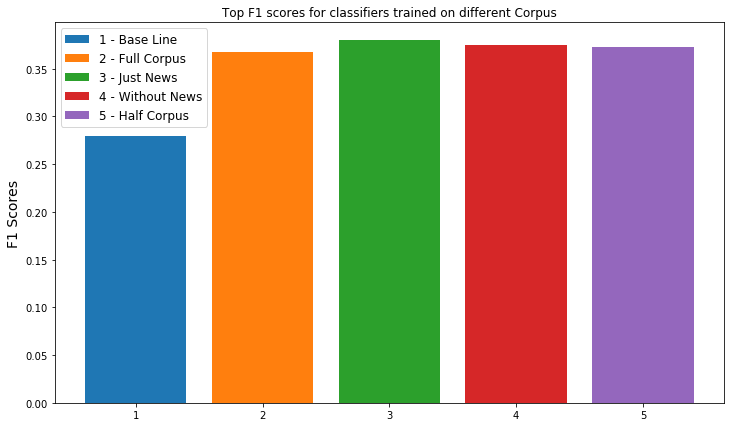

In [44]:
plt.figure(figsize=(12,7))

plt.bar(1, base_line, label='1 - Base Line')
plt.bar(2, full_corpus, label='2 - Full Corpus')
plt.bar(3, just_news, label='3 - Just News')
plt.bar(4, without_news, label='4 - Without News')
plt.bar(5, half_corpus, label = "5 - Half Corpus")

title = "Top F1 scores for classifiers trained on different Corpus"
plt.title(title)
plt.ylabel("F1 Scores", fontsize=14)

plt.legend(prop={'size': 12})

plt.show()

Alright moving on, Technique 2, building a classifier from scratch doesn't make as much sense to test on this dataset, so I will move on to 3.Technique 3 involves again splitting the testing data into train split, and then using a look at the test set to generate key words. We will first try the most naive approach possible only looking at word frequency in class X, and then move onto applying tf-idf, and viewing the whole training set.

In [45]:
#Redfine X_train and y_test, lets say with class 9 this time, ratio of 4
y_test = create_test_labels(9, twenty_test.target)
X_train, y_train = create_train_set(9, 4, twenty_train_data_proc, twenty_train.target)

In [46]:
train_data = zip (X_train, y_train)

class_X = []
not_class_X = []

for line,label in train_data:
    if (label == 1):
        class_X.append(line)
    else:
        not_class_X.append(line)
        
len(class_X)

597

In [47]:
#Get the word count for every word in class X

#Use a counter from python collections to get a quick word count
cnt_class_X = collections.Counter()

for line in class_X:
    words = nltk.word_tokenize(line)
    
    for word in words:
        cnt_class_X[word] += 1

In [48]:
#Print out the most common 20 words
cnt_class_X.most_common(20)

[(',', 6617),
 ('.', 5964),
 ('>', 5930),
 ('--', 5753),
 ('the', 5616),
 (':', 4774),
 (')', 2673),
 ('a', 2439),
 ('to', 2346),
 ('(', 2189),
 ('in', 2164),
 ('of', 2106),
 ('and', 2105),
 ('@', 1985),
 ('i', 1906),
 ('is', 1477),
 ('that', 1417),
 ('?', 1159),
 ('he', 1140),
 ('!', 1123)]

Alright, it seems pretty clear from our naive first attempt that taking into account term frequency is almost invaluable, with all 20 of the top 'words' being extremly generic, and revealing no pertinent class information. Before using any of sklearns built into tf-idf, lets try using a neat feature of Counter objects, which lets us subtract the counts of one counter from another

In [49]:
cnt_not_class_X = collections.Counter()

for line in not_class_X:
    words = nltk.word_tokenize(line)
    
    for word in words:
        cnt_not_class_X[word] += 1

In [50]:
#Might as well take a peak the not_x most common as well..
cnt_not_class_X.most_common(20)

[('>', 36428),
 (',', 35473),
 ('the', 30717),
 ('.', 30006),
 (':', 25031),
 ('--', 20938),
 (')', 16026),
 ('(', 15924),
 ('to', 15243),
 ('of', 14833),
 ('@', 13401),
 ('a', 12817),
 ('and', 12209),
 ('i', 10672),
 ('in', 10060),
 ('is', 9464),
 ('ax', 9107),
 ('?', 8689),
 ("''", 8282),
 ('that', 8276)]

These look awfully simmilar, so the next reasonable step is to subtract these counts from the first one

In [51]:
cnt_class_X.subtract(cnt_not_class_X)

In [52]:
cnt_class_X.most_common(20)

[('basebal', 289),
 ('team', 273),
 ('pitch', 265),
 ('game', 239),
 ('player', 221),
 ('hit', 210),
 ('win', 199),
 ('cub', 164),
 ('brave', 156),
 ('season', 149),
 ('score', 140),
 ('pitcher', 137),
 ('philli', 137),
 ('leagu', 128),
 ('hitter', 127),
 ('alomar', 116),
 ('fan', 111),
 ('bat', 106),
 ('yanke', 103),
 ('sox', 103)]

In [53]:
twenty_train.target_names[9]

'rec.sport.baseball'

These look a lot better, and is clear now that class 9 is about baseball, as confirmed by checking the target names. It also reveals a large potential flaw, where by only using one word, if we were to use these key words in a general search of the corpus we are almost gaurenteed to turn up a great deal of unrelated sentences. For example 'fan', doesn't imply only baseball, it just means that within the twenty news dataset, and our limited training set, fan ussually shows up with baseball. This raises two issues to deal with before actually testing, making sure the word is actually specific to the subject and can't be easily generalized, and related, the issue of 1-grams vs. n-grams. The first of these issues is far harder to solve, but by dealing with the second, we may reduce it's sway.

In [54]:
#Try with 2-gram first
cnt_class_X = get_N_Gram_Count(class_X, 2)
cnt_not_class_X = get_N_Gram_Count(not_class_X, 2)

cnt_class_X.subtract(cnt_not_class_X)

In [55]:
cnt_class_X.most_common(20)

[(' the brave', 94),
 (' last year', 89),
 (' 0 0', 87),
 (' game ,', 80),
 (' this year', 76),
 (" he 's", 63),
 (' the cub', 62),
 (' home run', 59),
 (' hall of', 59),
 (' red sox', 52),
 (' @ cs.cornell.edu', 52),
 (' in basebal', 52),
 (' the philli', 51),
 (' a team', 51),
 (' basebal .', 49),
 (' of fame', 49),
 (' the team', 46),
 (' win the', 46),
 (' basebal player', 45),
 (' year .', 44)]

Alright, these seem to be a little more what we are looking for, but we still can't quite just plug these results in blind, e.g. '0 0' doesn't seem to have much to do with baseball, and 'game ,' doesn't have much information to it. Let's just take a look at 3-gram, though I doubt it will be much better.

In [56]:
cnt_class_X = get_N_Gram_Count(class_X, 3)
cnt_not_class_X = get_N_Gram_Count(not_class_X, 3)

cnt_class_X.subtract(cnt_not_class_X)

In [57]:
cnt_class_X.most_common(20)

[(' 0 0 0', 53),
 (' hall of fame', 50),
 (' the hall of', 39),
 (' tedward @ cs.cornell.edu', 38),
 (' ( edward [', 37),
 (' ] fischer )', 37),
 (' edward [ ted', 36),
 (' [ ted ]', 36),
 (' ted ] fischer', 36),
 (' jewish basebal player', 35),
 (' basebal player ?', 34),
 (' cs.cornell.edu ( edward', 34),
 (' @ cs.cornell.edu (', 33),
 (' re : jewish', 32),
 (' : jewish basebal', 32),
 (' cub suck cub', 32),
 (' mss @ netcom.com', 30),
 (' this year .', 30),
 (' ( roger lustig', 30),
 (' roger lustig )', 30)]

Okay, it's safe to say the 3-gram starts returning some really un-usable keyword. While it would ideally be avoided, I think this approach will also require human input at this step. I will generate one's I believe to be useful from the various printed lists, this atleast helps the human come up with keywords.

In [58]:
#What I could come up with from what was printed above, pretty much just baseball, and different teams.
baseball_key_words = ['basebal', 'the cubs', 'red sox', 'major leagu', 'the yanke', 'the philli', 'the brave']

After adding these new instances, we have two options for introducing more instances of not class X to training data, the first is add more from the twenty news group data, and the second is to introduce examples from the corpus. As at least in this case the number of instances found is more than our whole training set, it seems we are forced to add from the corpus. Note: we already have the trainQuickClassifier avaliable to grab us instances, so me might as well add both at once to the test data.

In [59]:
#Search the corpus for all instances of the keywords, and get counter examples as well
#Use ratio 4 like above
lines_with_key, y = createQuickTrainingData(baseball_key_words, 4)
len(lines_with_key)

53045

In [60]:
for line in lines_with_key:
    X_train.append(line)
for line in y:
    y_train.append(line)

In [61]:
#Check the new size of the training set
len(y_train)

56030

In [62]:
X_test = twenty_test_data_proc

Alright, now that we have our new classifier, it is time to test it on X_test, and y_test

In [63]:
#Lets use some of the information we found above when defining our initial text clf
#Specifically we are already using ratio 4, lets use 'modified_huber', and ngram = (1,2), and lets start with
#max_features = 1000
text_clf = Pipeline([('vect', CountVectorizer(ngram_range=(1,2), max_features=1000)),('tfidf', TfidfTransformer()),
                             ('clf', SGDClassifier(loss='modified_huber', penalty='l2', alpha=1e-3,
                               random_state=22, max_iter=10))])


get_metrics(text_clf, X_train, X_test, y_train, y_test)

(0.58022690437601299, 0.8136363636363636, 0.45088161209068012)

Frankly these are not great results, but before we come to any conclusions I think it would be worthwhile to modify the GridSearch function to work with this approach, and to preform a broader test. 

In [64]:
#Note: the ModifiedGridSearch now takes the extra param class_num and class_keys, lets define the search params
loss_functions = ['modified_huber'] #Only going to try modified huber
n_grams = [(1,1),(1,2),(1,3)]
max_features_options = [None, 500, 1000]
ratio_range = [1,7]

#And run it
results = ModifiedGridSearch(loss_functions, n_grams, max_features_options, ratio_range, 9, baseball_key_words)

25 / 54
50 / 54


In [65]:
#As used above save the best score for each for later plotting
baseball = printF1(results)

Top 10
f1 score:  0.675642594859 for [2, 'modified_huber', (1, 1), None]
f1 score:  0.653846153846 for [2, 'modified_huber', (1, 2), 500]
f1 score:  0.653796653797 for [2, 'modified_huber', (1, 3), 500]
f1 score:  0.650292397661 for [2, 'modified_huber', (1, 1), 1000]
f1 score:  0.647130647131 for [2, 'modified_huber', (1, 2), 1000]
f1 score:  0.643031784841 for [2, 'modified_huber', (1, 3), 1000]
f1 score:  0.640804597701 for [3, 'modified_huber', (1, 1), None]
f1 score:  0.639455782313 for [3, 'modified_huber', (1, 1), 1000]
f1 score:  0.635622817229 for [2, 'modified_huber', (1, 1), 500]
f1 score:  0.634482758621 for [3, 'modified_huber', (1, 1), 500]
Bottom 5
f1 score:  0.45652173913 for [6, 'modified_huber', (1, 3), 500]
f1 score:  0.415162454874 for [6, 'modified_huber', (1, 2), None]
f1 score:  0.394366197183 for [6, 'modified_huber', (1, 3), None]
f1 score:  0.337373737374 for [1, 'modified_huber', (1, 2), None]
f1 score:  0.258040935673 for [1, 'modified_huber', (1, 3), None]


After a more comprehensive search, we were able to get closer results to the baseline, yet it still falls signifigantly short. It is important to note though, these results are based on only one key word search. I will re-run the search, using stricter margins to increase run time.

In [66]:
#Lets try with different baseball_keywords... or just basebal
baseball_key_words = ['basebal']

max_features_options = [200, 500, 1000]  #200 instead of none
ratio_range = [2,4]  #Top results all 2 or 3

#And re-run it
results = ModifiedGridSearch(loss_functions, n_grams, max_features_options, ratio_range, 9, baseball_key_words)

In [67]:
baseball_less = printF1(results)

Top 10
f1 score:  0.647427854454 for [2, 'modified_huber', (1, 1), 1000]
f1 score:  0.632944228275 for [2, 'modified_huber', (1, 3), 1000]
f1 score:  0.631168831169 for [2, 'modified_huber', (1, 2), 1000]
f1 score:  0.610899873257 for [2, 'modified_huber', (1, 1), 500]
f1 score:  0.608955223881 for [3, 'modified_huber', (1, 1), 1000]
f1 score:  0.606770833333 for [2, 'modified_huber', (1, 3), 500]
f1 score:  0.60103626943 for [2, 'modified_huber', (1, 2), 500]
f1 score:  0.574886535552 for [3, 'modified_huber', (1, 2), 1000]
f1 score:  0.571428571429 for [3, 'modified_huber', (1, 3), 1000]
f1 score:  0.556732223903 for [3, 'modified_huber', (1, 2), 500]
Bottom 5
f1 score:  0.513812154696 for [2, 'modified_huber', (1, 2), 200]
f1 score:  0.508990318119 for [2, 'modified_huber', (1, 3), 200]
f1 score:  0.478605388273 for [3, 'modified_huber', (1, 1), 200]
f1 score:  0.475409836066 for [3, 'modified_huber', (1, 2), 200]
f1 score:  0.470588235294 for [3, 'modified_huber', (1, 3), 200]


In [68]:
#Now try running the baseline without any keywords
leave_this_blank = []

results = ModifiedGridSearch(loss_functions, n_grams, max_features_options, ratio_range, 9, leave_this_blank)

In [69]:
baseball_base = printF1(results)

Top 10
f1 score:  0.690376569038 for [2, 'modified_huber', (1, 1), 1000]
f1 score:  0.685897435897 for [3, 'modified_huber', (1, 1), 1000]
f1 score:  0.674468085106 for [3, 'modified_huber', (1, 3), 1000]
f1 score:  0.674443266172 for [3, 'modified_huber', (1, 2), 1000]
f1 score:  0.670081967213 for [2, 'modified_huber', (1, 2), 1000]
f1 score:  0.668717948718 for [2, 'modified_huber', (1, 3), 1000]
f1 score:  0.625118035883 for [2, 'modified_huber', (1, 1), 500]
f1 score:  0.580392156863 for [3, 'modified_huber', (1, 1), 500]
f1 score:  0.570895522388 for [2, 'modified_huber', (1, 3), 500]
f1 score:  0.566420664207 for [2, 'modified_huber', (1, 2), 500]
Bottom 5
f1 score:  0.478460128323 for [2, 'modified_huber', (1, 2), 200]
f1 score:  0.476964769648 for [2, 'modified_huber', (1, 3), 200]
f1 score:  0.433544303797 for [3, 'modified_huber', (1, 1), 200]
f1 score:  0.421585160202 for [3, 'modified_huber', (1, 2), 200]
f1 score:  0.416326530612 for [3, 'modified_huber', (1, 3), 200]


We can also try with other classes, e.g. Space

In [70]:
getKeyWords(14,4)

sci.space
N gram = 1
[(' space', 1087), (' orbit', 500), (' launch', 462), (' nasa', 384), (' satellit', 307), (' moon', 278), (' mission', 247), (' shuttl', 223), (' lunar', 216), (' henri', 193)]
N gram = 2
[(' the moon', 185), (' @ zoo.toronto.edu', 115), (' the space', 107), (' space station', 100), (' : space', 96), (' henri spencer', 94), (' nsmca @', 91), (' henri @', 90), (' prb @', 84), (' pat )', 84)]


In [71]:
space_key_words = ['the moon', ' nasa', ' space station', 'satellit', 'space shuttl', 'lunar landing']

#Re-run with class 14, space
results = ModifiedGridSearch(loss_functions, n_grams, max_features_options, ratio_range, 14, space_key_words)

In [72]:
space = printF1(results)

Top 10
f1 score:  0.70725388601 for [2, 'modified_huber', (1, 1), 1000]
f1 score:  0.684563758389 for [2, 'modified_huber', (1, 3), 1000]
f1 score:  0.679194630872 for [2, 'modified_huber', (1, 2), 1000]
f1 score:  0.667553191489 for [2, 'modified_huber', (1, 1), 500]
f1 score:  0.65211062591 for [3, 'modified_huber', (1, 1), 1000]
f1 score:  0.631892697466 for [3, 'modified_huber', (1, 2), 1000]
f1 score:  0.62874251497 for [3, 'modified_huber', (1, 3), 1000]
f1 score:  0.606488011283 for [2, 'modified_huber', (1, 2), 500]
f1 score:  0.604255319149 for [2, 'modified_huber', (1, 3), 500]
f1 score:  0.586552217454 for [2, 'modified_huber', (1, 1), 200]
Bottom 5
f1 score:  0.56346749226 for [3, 'modified_huber', (1, 2), 500]
f1 score:  0.563218390805 for [2, 'modified_huber', (1, 3), 200]
f1 score:  0.53023255814 for [3, 'modified_huber', (1, 2), 200]
f1 score:  0.53023255814 for [3, 'modified_huber', (1, 3), 200]
f1 score:  0.524844720497 for [3, 'modified_huber', (1, 1), 200]


In [73]:
#Now get the baseline
results = ModifiedGridSearch(loss_functions, n_grams, max_features_options, ratio_range, 14, leave_this_blank)

In [74]:
space_base = printF1(results)

Top 10
f1 score:  0.835978835979 for [3, 'modified_huber', (1, 1), 1000]
f1 score:  0.816864295125 for [2, 'modified_huber', (1, 1), 1000]
f1 score:  0.802614379085 for [2, 'modified_huber', (1, 2), 1000]
f1 score:  0.798948751643 for [2, 'modified_huber', (1, 3), 1000]
f1 score:  0.79679144385 for [3, 'modified_huber', (1, 3), 1000]
f1 score:  0.795727636849 for [3, 'modified_huber', (1, 2), 1000]
f1 score:  0.757697456493 for [2, 'modified_huber', (1, 1), 500]
f1 score:  0.752317880795 for [3, 'modified_huber', (1, 1), 500]
f1 score:  0.748663101604 for [3, 'modified_huber', (1, 3), 500]
f1 score:  0.745308310992 for [2, 'modified_huber', (1, 3), 500]
Bottom 5
f1 score:  0.63202247191 for [3, 'modified_huber', (1, 2), 200]
f1 score:  0.628853267571 for [2, 'modified_huber', (1, 1), 200]
f1 score:  0.607866507747 for [2, 'modified_huber', (1, 3), 200]
f1 score:  0.606420927467 for [2, 'modified_huber', (1, 2), 200]
f1 score:  0.597364568082 for [3, 'modified_huber', (1, 3), 200]


Now try with middle east keywords

In [75]:
getKeyWords(17,4)

talk.politics.mideast
N gram = 1
[(' armenian', 1264), (' israel', 847), (' isra', 791), (' were', 734), (' turkish', 709), (' jew', 559), (' arab', 499), (' armenia', 363), (' turk', 361), (' kill', 333)]
N gram = 2
[(' | >', 621), (' the armenian', 486), (' , ``', 263), (' serdar argic', 245), (' the turkish', 241), (' > |', 225), (' they were', 214), (' the isra', 186), (' center for', 175), (" . '", 154)]


In [76]:
middle_east_key_words = [' israel', ' armenian', ' turkish', ' arab', ' jew', ' armenia', ' serdar argic']

results = ModifiedGridSearch(loss_functions, n_grams, max_features_options, ratio_range, 17, middle_east_key_words)

In [77]:
middle_east = printF1(results)

Top 10
f1 score:  0.741239892183 for [3, 'modified_huber', (1, 1), 500]
f1 score:  0.733590733591 for [3, 'modified_huber', (1, 1), 1000]
f1 score:  0.730870712401 for [2, 'modified_huber', (1, 2), 200]
f1 score:  0.729194187583 for [2, 'modified_huber', (1, 3), 200]
f1 score:  0.725034199726 for [3, 'modified_huber', (1, 3), 500]
f1 score:  0.723055934516 for [3, 'modified_huber', (1, 2), 500]
f1 score:  0.715953307393 for [2, 'modified_huber', (1, 1), 200]
f1 score:  0.712328767123 for [3, 'modified_huber', (1, 1), 200]
f1 score:  0.710327455919 for [3, 'modified_huber', (1, 3), 1000]
f1 score:  0.71 for [3, 'modified_huber', (1, 2), 1000]
Bottom 5
f1 score:  0.625 for [2, 'modified_huber', (1, 3), 500]
f1 score:  0.622317596567 for [2, 'modified_huber', (1, 2), 500]
f1 score:  0.620618556701 for [2, 'modified_huber', (1, 1), 1000]
f1 score:  0.595450049456 for [2, 'modified_huber', (1, 3), 1000]
f1 score:  0.591355599214 for [2, 'modified_huber', (1, 2), 1000]


In [78]:
#And re-run it with no keywords
results = ModifiedGridSearch(loss_functions, n_grams, max_features_options, ratio_range, 17, leave_this_blank)

In [79]:
middle_east_base = printF1(results)

Top 10
f1 score:  0.816216216216 for [2, 'modified_huber', (1, 1), 1000]
f1 score:  0.795731707317 for [3, 'modified_huber', (1, 3), 1000]
f1 score:  0.792048929664 for [3, 'modified_huber', (1, 2), 1000]
f1 score:  0.783532536521 for [2, 'modified_huber', (1, 2), 1000]
f1 score:  0.781914893617 for [2, 'modified_huber', (1, 3), 1000]
f1 score:  0.781538461538 for [3, 'modified_huber', (1, 1), 1000]
f1 score:  0.769465648855 for [3, 'modified_huber', (1, 2), 500]
f1 score:  0.768049155146 for [3, 'modified_huber', (1, 3), 500]
f1 score:  0.753125 for [3, 'modified_huber', (1, 1), 500]
f1 score:  0.742637644046 for [2, 'modified_huber', (1, 3), 500]
Bottom 5
f1 score:  0.726094003241 for [3, 'modified_huber', (1, 2), 200]
f1 score:  0.725806451613 for [3, 'modified_huber', (1, 1), 200]
f1 score:  0.676129032258 for [2, 'modified_huber', (1, 1), 200]
f1 score:  0.675224646983 for [2, 'modified_huber', (1, 3), 200]
f1 score:  0.668367346939 for [2, 'modified_huber', (1, 2), 200]


So... its pretty clear from a range of tests that this technique does not work. In fact it produces about 10% worse accuracy, so that isn't very encouraging.

Lets create a plot comparing accuracy of the method to baseline.

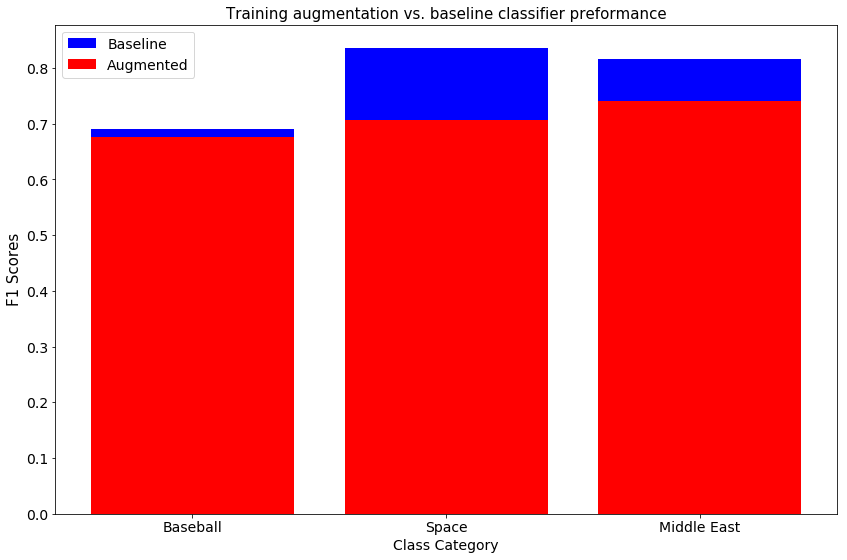

In [93]:
plt.figure(figsize=(14,9))

labels = ['Baseball', 'Space', 'Middle East']

plt.bar(1, baseball_base, color = 'b', label = 'Baseline')
plt.bar(1, baseball, color = 'r', label = 'Augmented')

plt.bar(2, space_base, color = 'b')
plt.bar(2, space, color = 'r')

plt.bar(3, middle_east_base, color = 'b')
plt.bar(3, middle_east, color = 'r')

plt.xticks([1,2,3], labels)

title = "Training augmentation vs. baseline classifier preformance"
plt.title(title, fontsize=15)
plt.ylabel("F1 Scores", fontsize=15)
plt.xlabel("Class Category", fontsize=14)

plt.tick_params(labelsize=14) 

plt.legend(prop={'size': 14})
plt.show()

The next technique I will explore involves choosing a classifier with very good precision, and preferably good recall. I've printed above, the results sorted by precision, and the top one looks promising, but i'll do a more thorough search.

In [94]:
#Redefine the search criteria
loss_functions = ['modified_huber','hinge'] 
n_grams = [(1,1),(1,2),(1,3)]
max_features_options = [200, 500, 1000, None]  
ratio_range = [2,10]  

#And re-run it with notably no key words!
results = ModifiedGridSearch(loss_functions, n_grams, max_features_options, ratio_range, 17, leave_this_blank)

25 / 192
50 / 192
75 / 192
100 / 192
125 / 192
150 / 192
175 / 192


In [95]:
printPR(results)

Top 10
prescision score:  1.0 for [5, 'hinge', (1, 2), None] recall:  0.582446808511
prescision score:  1.0 for [6, 'modified_huber', (1, 2), None] recall:  0.627659574468
prescision score:  1.0 for [6, 'hinge', (1, 2), None] recall:  0.563829787234
prescision score:  1.0 for [6, 'hinge', (1, 3), None] recall:  0.553191489362
prescision score:  1.0 for [7, 'hinge', (1, 2), None] recall:  0.529255319149
prescision score:  1.0 for [7, 'hinge', (1, 3), None] recall:  0.523936170213
prescision score:  1.0 for [8, 'modified_huber', (1, 2), None] recall:  0.577127659574
prescision score:  1.0 for [8, 'hinge', (1, 1), None] recall:  0.542553191489
prescision score:  1.0 for [8, 'hinge', (1, 2), 200] recall:  0.125
prescision score:  1.0 for [8, 'hinge', (1, 2), None] recall:  0.502659574468


Finding a balance above seems to be - prescision score:  0.989323843416 for [3, 'modified_huber', (1, 1), None] recall:  0.739361702128,  since all the precision scores are very high, and this one has the highest recall.

In [125]:
#Define the classifier with the settings found above,
text_clf = Pipeline([('vect', CountVectorizer(ngram_range=(1,1), max_features=None)),('tfidf', TfidfTransformer()),
                             ('clf', SGDClassifier(loss='modified_huber', penalty='l2', alpha=1e-3,
                               random_state=22, max_iter=5))])

In [126]:
#Test with class 17
y_test = create_test_labels(17, twenty_test.target)
X_train, y_train = create_train_set(17, 5, twenty_train_data_proc, twenty_train.target)

In [127]:
#Confirm that it works
print(get_metrics(text_clf, X_train, twenty_test_data_proc, y_train, y_test))

(0.82737169517884923, 0.99625468164794007, 0.70744680851063835)


In [128]:
#Lets test this on a small subset
predict = text_clf.predict(corpus[:6000000])

In [129]:
predict_posts = []

#Go through and see which posts were labelled 1 by the classifier
for num in range(len(predict)):
    if (predict[num] == 1):
        predict_posts.append(corpus[num])

In [130]:
#Lets see how many it found,
len(predict_posts)

2456

In [131]:
for line in predict_posts:
    X_train.append(line)
    y_train.append(1)

In [132]:
text_clf.fit(X_train, y_train)

#And lastly take a look at the metrics
get_metrics(text_clf, X_train, X_test, y_train, y_test)

(0.8179012345679012, 0.97426470588235292, 0.70478723404255317)

Interesting so, the performance stays at around the same accuracy, and seems to be kind of working.

I will print out a few of the predicted posts to confirm this...

In [134]:
print(predict_posts[500:510])

[' the un clear has a serious problem with israel .', ' they have the stronger militari , the stronger alli , more money , more resourc , and a valid reason to do just about anyth given the palestinian and their elect govern continu terror and act of war against the state of israel .', ' student and professor who use hate anti-jewish rhetor and imageri , who activ promot the dismantl of the jewish state , and who support terror against jew , do act to creat a hostil and threaten environ for mani jewish student , some of whom report at time feel physic unsaf , emot and intellectu harass and intimid by peer and professor , isol from their fellow student , and unfair treat by faculti and administr .', ' yeah that and they specif massacr jew in know jewish town that had been there centuri before .', ' you have all been post exampl of isra protest in support of palestinian .', " dude.. you did n't get what he 's tri to say.. yes muslim countri in general seem the culprit and are the culprit

These actually seem fairly accuracte, I wonder what will happen if we search using this new classifier on another 600,000.

In [136]:
predict = text_clf.predict(corpus[6000000:12000000])

In [137]:
predict_posts = []

#Go through and see which posts were labelled 1 by the classifier
for num in range(len(predict)):
    if (predict[num] == 1):
        predict_posts.append(corpus[num+600000])

In [138]:
#Lets see how many it found,
len(predict_posts)

618332

In [139]:
for line in predict_posts:
    X_train.append(line)
    y_train.append(1)

In [140]:
text_clf.fit(X_train, y_train)

get_metrics(text_clf, X_train, X_test, y_train, y_test)

(0.095105602630580502, 0.049926968530075687, 1.0)

Hmm something definitly went wrong that second time, it seems the approach doesn't do very well with the train-retrain method